In [1]:
from swat import *
import swat as sw
from pprint import pprint
%matplotlib inline
import matplotlib
import sys

sys.path.append('C:\\Users\\weshiz\\Documents\\GitHub\\modify\\python-dlpy')
sys.path.append('C:\\Users\\weshiz\\Documents\\GitHub\\python-fcmp')
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.images import *
from dlpy.model import *
from python_fcmp.parser import *
from python_fcmp.decorator import *
from python_fcmp import fcmp
from dlpy.lr_scheduler import *
from dlpy.network import *

import numpy as np
import pandas as pd

In [2]:
s = sw.CAS('dlgrd009', 13300)
s.loadactionset('deeplearn')
s.loadactionset('clustering')

NOTE: Added action set 'deeplearn'.
NOTE: Added action set 'clustering'.


[actionset]

 'clustering'

+ Elapsed: 0.00174s, user: 0.00137s, sys: 0.000312s, mem: 0.209mb

In [3]:
# https://go.documentation.sas.com/?docsetId=lesysoptsref&docsetTarget=n16rhscxem9ljwn1kuhn5170xkbg.htm&docsetVersion=9.4&locale=en
s.sessionProp.setSessOpt(caslib='CASUSER', cmplib="CASUSER.fcmpfunction", cmpopt="ALL")

NOTE: 'CASUSER(weshiz)' is now the active caslib.


+ Elapsed: 0.000262s, user: 0.000106s, sys: 9.5e-05s, mem: 0.256mb

In [4]:
s.caslibinfo()

,Name,Type,Description,Path,Definition,Subdirs,Local,Active,Personal,Hidden,Transient
0,CASTestTmp,PATH,castest's test files,/bigdisk/lax/castest/,,1.0,0.0,0.0,0.0,0.0,0.0
1,CASUSER(weshiz),PATH,Personal File System Caslib,/u/weshiz/,,1.0,0.0,1.0,1.0,0.0,1.0
2,Formats,PATH,Format Caslib,/bigdisk/lax/formats/,,1.0,0.0,0.0,0.0,0.0,0.0


In [5]:
s.tableinfo(caslib='casuser')

NOTE: No tables are available in caslib CASUSER(weshiz) of Cloud Analytic Services.


+ Elapsed: 0.00025s, user: 0.000118s, sys: 9.8e-05s, mem: 0.284mb

### Define Triplet Loss Forward and Backward Function

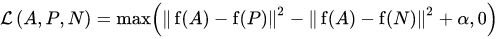

In [6]:
@out_args('y_out')  # pass by reference
@cast_array('srcY', 'weights', 'y_out')  # declare the arguments as array type
def forward_prop(srcHeight, srcWidth, srcDepth, srcY, weights, y_out):
    fcmp.reshape(weights, (1, 1, 1))
    margin = 2.0
    n_feature = int(srcWidth / 3)
    ap = 0.0
    an = 0.0
    for i in range(n_feature):
        ap = ap + (srcY[i] - srcY[n_feature + i]) ** 2
        an = an + (srcY[i] - srcY[2 * n_feature + i]) ** 2
    ap = ap ** 0.5
    an = an ** 0.5
    diff = ap - an + margin
    y_out[0] = max(diff, 0.0)
    return y_out[0]

@out_args('gradient_out', 'srcDeltas_out')
@cast_array('srcY', 'Y', 'weights', 'deltas', 'gradient_out', 'srcDeltas_out')
def back_prop(srcHeight, srcWidth, srcDepth, srcY, Y, weights,
              deltas, gradient_out, srcDeltas_out):
    n_feature = int(srcWidth / 3)
    for i in range(n_feature):
        if Y[0] == 0.0:
            srcDeltas_out[i] = 0.0
            srcDeltas_out[n_feature + i ] = 0.0
            srcDeltas_out[2 * n_feature + i] = 0.0
        else:
            srcDeltas_out[i] = deltas[0] * (srcY[2 * n_feature + i] - srcY[n_feature + i]) # anchor
            srcDeltas_out[n_feature + i] = deltas[0] * (srcY[i] - srcY[n_feature + i]) # positive
            srcDeltas_out[2 * n_feature + i] = deltas[0] * (srcY[2 * n_feature + i] - srcY[i]) # negative
    return

def dummy_loss(t, target):
    return t

Arguments, srcY, weights, y_out, are casted to array type
Arguments, y_out, are declared as outargs.
Arguments, srcY, Y, weights, deltas, gradient_out, srcDeltas_out, are casted to array type
Arguments, gradient_out, srcDeltas_out, are declared as outargs.


In [7]:
# get FCMP code of forward_prop
forward_fcmp_code = python_to_fcmp(func=forward_prop, print=True)
# 2 * 3 + 2 + 1

('function forward_prop(srcHeight, srcWidth, srcDepth, srcY[*], weights[*], y_out[*]);outargs y_out;\n'
 '    margin = 2.0;\n'
 '    n_feature = int((srcWidth / 3));\n'
 '    ap = 0.0;\n'
 '    an = 0.0;\n'
 '    do i = 0 to n_feature - 1 by 1;\n'
 '        ap = (ap + (srcY[i + 1] - srcY[(n_feature + i) + 1]) ** 2);\n'
 '        an = (an + (srcY[i + 1] - srcY[((2 * n_feature) + i) + 1]) ** 2);\n'
 '    end;\n'
 '    ap = ap ** 0.5;\n'
 '    an = an ** 0.5;\n'
 '    diff = ((ap - an) + margin);\n'
 '    y_out[1] = max(diff, 0.0);\n'
 '    return (y_out[1]);\n'
 'endsub;\n')


In [8]:
# get FCMP code of back_prop
backward_fcmp_code = python_to_fcmp(func=back_prop, print=True)

('function back_prop(srcHeight, srcWidth, srcDepth, srcY[*], Y[*], weights[*], deltas[*], gradient_out[*], srcDeltas_out[*]);outargs gradient_out, srcDeltas_out;\n'
 '    n_feature = int((srcWidth / 3));\n'
 '    do i = 0 to n_feature - 1 by 1;\n'
 '        if Y[1] eq 0.0 then do;\n'
 '            srcDeltas_out[i + 1] = 0.0;\n'
 '            srcDeltas_out[(n_feature + i) + 1] = 0.0;\n'
 '            srcDeltas_out[((2 * n_feature) + i) + 1] = 0.0;\n'
 '        end;\n'
 '        else do;\n'
 '            srcDeltas_out[i + 1] = (deltas[1] * (srcY[((2 * n_feature) + i) + 1] - srcY[(n_feature + i) + 1]));\n'
 '            srcDeltas_out[(n_feature + i) + 1] = (deltas[1] * (srcY[i + 1] - srcY[(n_feature + i) + 1]));\n'
 '            srcDeltas_out[((2 * n_feature) + i) + 1] = (deltas[1] * (srcY[((2 * n_feature) + i) + 1] - srcY[i + 1]));\n'
 '        end;\n'
 '    end;\n'
 '    return ;\n'
 'endsub;\n')


In [9]:
dummy_loss_code = python_to_fcmp(dummy_loss, True)

'function dummy_loss(t, target);\n    return (t);\nendsub;\n'


In [10]:
backward_fcmp_code

'function back_prop(srcHeight, srcWidth, srcDepth, srcY[*], Y[*], weights[*], deltas[*], gradient_out[*], srcDeltas_out[*]);outargs gradient_out, srcDeltas_out;\n    n_feature = int((srcWidth / 3));\n    do i = 0 to n_feature - 1 by 1;\n        if Y[1] eq 0.0 then do;\n            srcDeltas_out[i + 1] = 0.0;\n            srcDeltas_out[(n_feature + i) + 1] = 0.0;\n            srcDeltas_out[((2 * n_feature) + i) + 1] = 0.0;\n        end;\n        else do;\n            srcDeltas_out[i + 1] = (deltas[1] * (srcY[((2 * n_feature) + i) + 1] - srcY[(n_feature + i) + 1]));\n            srcDeltas_out[(n_feature + i) + 1] = (deltas[1] * (srcY[i + 1] - srcY[(n_feature + i) + 1]));\n            srcDeltas_out[((2 * n_feature) + i) + 1] = (deltas[1] * (srcY[((2 * n_feature) + i) + 1] - srcY[i + 1]));\n        end;\n    end;\n    return ;\nendsub;\n'

In [11]:
# register forward and backward function together
register_fcmp_routines(s,
                       routine_code=forward_fcmp_code + backward_fcmp_code + dummy_loss_code,
                       function_tbl_name='fcmpfunction')

NOTE: Cloud Analytic Services saved the file FCMPFUNCTION.sashdat in caslib CASUSER(weshiz).


### Define a model

In [12]:
model = Sequential(s, model_table='Simple_CNN')
model.add(InputLayer(3, 48, 96, scale=1.0/255, random_mutation='none')) # input image is 48 by 96
model.add(Conv2d(64, 7, include_bias=True, act='identity'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=True, act='relu'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=True, act='relu'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=True, act='relu'))
model.add(Pooling(2)) # 3, 6
model.add(Dense(16))
model.add(OutputLayer(n=1, act='sigmoid'))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [13]:
branch = model.to_functional_model(stop_layers=model.layers[-1])

In [14]:
inp1 = Input(**branch.layers[0].config, name='Input_layer_00') # tensor
branch1 = branch(inp1) # tensor
inp2 = Input(**branch.layers[0].config, name='Input_layer_01') # tensor
branch2 = branch(inp2) # tensor
inp3 = Input(**branch.layers[0].config, name='Input_layer_02') # tensor
branch3 = branch(inp3) # tensor

In [15]:
concat1 = Concat(name='Concat1')(branch1 + branch2 + branch3)

In [16]:
fcmp1 = FCMPLayer(width=1, height=1, depth=1, n_weights=0, 
                  forward_func='forward_prop', backward_func='back_prop',
                  name='FCMPLayer1')(concat1)

In [17]:
out1 = OutputLayer(act='identity', fcmp_err='dummy_loss', error='FCMPERR', name='outputLayer_1',
                   include_bias=False, full_connect=False)(fcmp1)

In [18]:
triplet_model = Model(s, inputs=[inp1, inp2, inp3], outputs=out1)

In [19]:
# share weigths between each branch
triplet_model.share_weights([{'Convo.1':['Convo.1_2', 'Convo.1_3']}, 
                             {'Convo.2':['Convo.2_2', 'Convo.2_3']}, 
                             {'Convo.3':['Convo.3_2', 'Convo.3_3']},
                             {'Convo.4':['Convo.4_2', 'Convo.4_3']},
                             {'F.C.1':['F.C.1_2', 'F.C.1_3']}])

In [20]:
triplet_model.compile()

NOTE: Model compiled successfully.


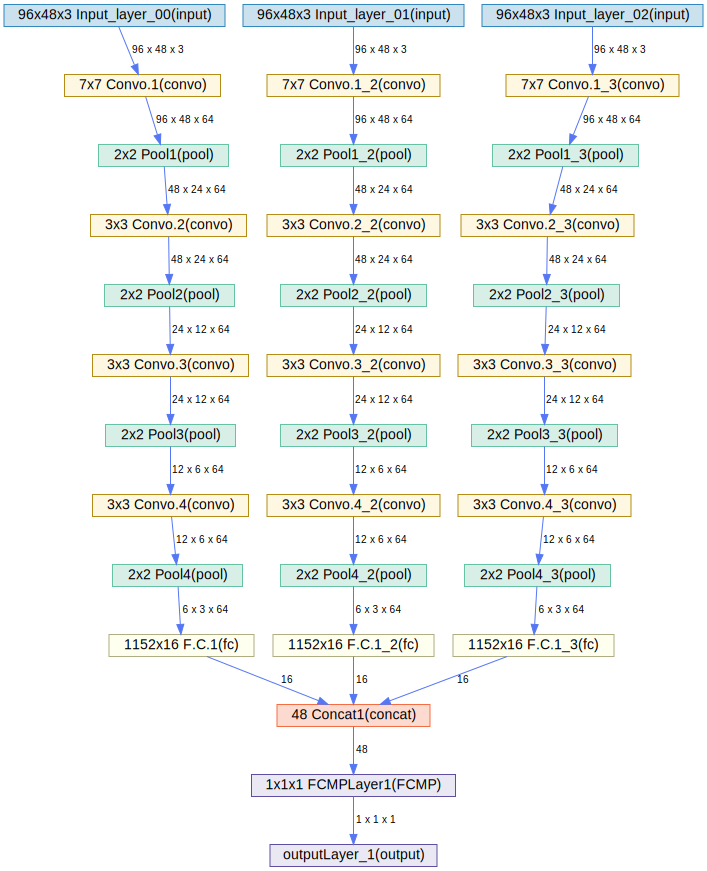

In [21]:
triplet_model.plot_network()

### Create a dataset

In [47]:
s.table.addcaslib(activeonadd=False,datasource={'srctype':'path'},
                  name='dnfs',path='/cas/DeepLearn/data/scisports_2019/team_classification_tf_Mark/training',
                  subdirectories=True)
s.table.loadTable(caslib='dnfs',path='Arsenal_CSKAMoskow_2018_04_05_triplet_sample.sashdat', 
                 casout=dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', replace=1))
s.alterTable(table='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', columns=[dict(name='uniqueid', rename='_id_')])
img_dlpy_tbl=ImageTable.from_table(s.CASTable('Arsenal_CSKAMoskow_2018_04_05_triplet_sample', 
                                              where='_id_ > 56005500'),
                                   image_col='_image_', label_col='_label_',path_col='_path_')

In [23]:
s.partition(dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', 
            where='_label_ not in ("keeper_CSKA", "keeper_Arsenal")'), 
            casout=dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', replace=1))
s.partition(dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', 
            where='_label1_ not in ("keeper_CSKA", "keeper_Arsenal")'), 
            casout=dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', replace=1))
s.partition(dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', 
            where='_label2_ not in ("keeper_CSKA", "keeper_Arsenal")'), 
            casout=dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', replace=1))

[caslib]

 'CASUSER(weshiz)'

[tableName]

 'ARSENAL_CSKAMOSKOW_2018_04_05_TRIPLET_SAMPLE'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('ARSENAL_CSKAMOSKOW_2018_04_05_TRIPLET_SAMPLE', caslib='CASUSER(weshiz)')

+ Elapsed: 0.441s, user: 1s, sys: 1.81s, mem: 552mb

In [24]:
s.fetch('Arsenal_CSKAMoskow_2018_04_05_triplet_sample', sastypes=False)

,_id_,_path_,_image_,_label_,isSelected,_image1_,_path1_,_label1_,_image2_,_path2_,_label2_
0,53002533.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Arsenal,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,referee
1,53002534.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Arsenal,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA
2,53002536.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Arsenal,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA
3,54005623.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,CSKA,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal
4,54005629.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Arsenal,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA
5,54005636.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,CSKA,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal
6,54005638.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Arsenal,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA
7,54005648.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,Arsenal,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA
8,54005649.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,referee,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,referee,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA
9,41003755.0,/cas/DeepLearn/data/scisports_2019/team_classi...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,CSKA,1.0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,CSKA,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,/cas/DeepLearn/data/scisports_2019/team_classi...,Arsenal


In [40]:
img_dlpy_tbl.numrows()

[numrows]

 41

+ Elapsed: 0.00015s, user: 0.00014s, mem: 0.409mb

### Python Client to check forward and backward

### Train

In [31]:
solver = VanillaSolver(clip_grad_max=100, clip_grad_min=-100, learning_rate=0.0001,
                       learning_rate_policy='step', gamma=0.1, step_size=30)
optimizer = Optimizer(algorithm=solver, seed=13309, max_epochs=15, log_level=3, mini_batch_size=32, reg_l2=0.0001)

In [33]:
triplet_model.fit(data='Arsenal_CSKAMoskow_2018_04_05_triplet_sample',
                  optimizer=optimizer,
                  n_threads=8,
                  data_specs=[{'type':'IMAGE', 'layer':'input_layer_00', 'data':'_image_'},
                              {'type':'IMAGE', 'layer':'input_layer_01', 'data':'_image1_'},
                              {'type':'IMAGE', 'layer':'input_layer_02', 'data':'_image2_'},
                              {'type':'numericnominal', 'layer':'outputLayer_1', 'data':'isSelected'}
                             ]
                 )

NOTE: Training from scratch.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 416112.
NOTE:  The approximate memory cost is 3273.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       0.29 (s).
NOTE:  The total number of threads on each worker is 8.
NOTE:  The total mini-batch size per thread on each worker is 32.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 256.
NOTE:  Target variable: isSelected
NOTE:  Number of input variables:     3
NOTE:  Number of numeric input variables:      3
NOTE:  Number of FCMP layers in model: 1
NOTE:  FCMP layer 'fcmplayer1' has input tensor size: width=48, height=1, depth=1
NOTE:  FCMP layer 'fcmplayer1' has output tensor size: width=1, height=1, depth=1
NOTE:  FCMP layer 'fcmplayer1' has 0 weights.
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   256   0.0001            1.897     0.8289    0.08158  

NOTE:    100   256   0.0001            1.882     0.8002    0.08158     0.90
NOTE:    101   256   0.0001            1.908     0.8477    0.08158     0.85
NOTE:    102   256   0.0001            1.894     0.8247    0.08158     0.90
NOTE:    103   256   0.0001            1.901     0.8363    0.08158     0.83
NOTE:    104   256   0.0001            1.893     0.8222    0.08158     0.84
NOTE:    105   256   0.0001            1.911     0.8547    0.08158     0.83
NOTE:    106   256   0.0001            1.882     0.8006    0.08158     0.82
NOTE:    107   256   0.0001            1.909     0.8482    0.08158     0.82
NOTE:    108   256   0.0001            1.872     0.7861    0.08158     0.82
NOTE:    109   256   0.0001            1.894      0.827    0.08158     0.82
NOTE:    110   256   0.0001            1.906      0.848    0.08158     0.82
NOTE:    111   256   0.0001            1.892     0.8191    0.08158     0.89
NOTE:    112   256   0.0001            1.914     0.8614    0.08158     0.83
NOTE:    113

NOTE:     42   256   0.0001            1.901     0.8431    0.08158     0.83
NOTE:     43   256   0.0001            1.887     0.8117    0.08158     0.83
NOTE:     44   256   0.0001            1.909     0.8602    0.08158     0.82
NOTE:     45   256   0.0001            1.904     0.8472    0.08158     0.83
NOTE:     46   256   0.0001            1.902     0.8407    0.08158     0.88
NOTE:     47   256   0.0001            1.884     0.8058    0.08158     0.83
NOTE:     48   256   0.0001            1.893      0.823    0.08158     0.89
NOTE:     49   256   0.0001              1.9     0.8384    0.08158     0.89
NOTE:     50   256   0.0001             1.89     0.8154    0.08158     0.94
NOTE:     51   256   0.0001            1.886     0.8179    0.08158     0.88
NOTE:     52   256   0.0001            1.889     0.8193    0.08158     0.84
NOTE:     53   256   0.0001            1.879     0.7995    0.08158     0.91
NOTE:     54   256   0.0001            1.896      0.826    0.08158     0.85
NOTE:     55

NOTE:    156   256   0.0001             1.89     0.8221    0.08158     0.90
NOTE:    157   256   0.0001             1.89     0.8212    0.08158     0.87
NOTE:    158   256   0.0001            1.871     0.7854    0.08158     0.82
NOTE:    159   256   0.0001            1.896     0.8285    0.08158     0.82
NOTE:    160   256   0.0001            1.886     0.8139    0.08158     0.83
NOTE:    161   256   0.0001            1.876     0.7969    0.08158     0.82
NOTE:    162   256   0.0001            1.902     0.8385    0.08158     0.83
NOTE:    163   256   0.0001            1.887     0.8123    0.08158     0.90
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  1        0.0001           1.892     0.8235   138.18
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   256   0.0001            1.884     0.8103    0.08158     0.87
NOTE:      1   256   0.0001            1.886     0.8121    0.08158     0.82
NOTE:      2   256   0.0001      

NOTE:     98   256   0.0001            1.897     0.8396    0.08158     0.87
NOTE:     99   256   0.0001            1.859     0.7648    0.08158     0.82
NOTE:    100   256   0.0001            1.875     0.7964    0.08158     0.81
NOTE:    101   256   0.0001            1.874      0.796    0.08158     0.90
NOTE:    102   256   0.0001             1.86     0.7722    0.08158     0.82
NOTE:    103   256   0.0001             1.89     0.8228    0.08158     0.82
NOTE:    104   256   0.0001            1.873      0.796    0.08158     0.88
NOTE:    105   256   0.0001            1.893     0.8287    0.08158     0.83
NOTE:    106   256   0.0001            1.869     0.7885    0.08158     0.83
NOTE:    107   256   0.0001            1.893     0.8283    0.08158     0.84
NOTE:    108   256   0.0001            1.884     0.8127    0.08158     0.83
NOTE:    109   256   0.0001            1.892     0.8287    0.08158     0.84
NOTE:    110   256   0.0001            1.893     0.8278    0.08158     0.84
NOTE:    111

NOTE:     43   256   0.0001            1.865     0.7828    0.08158     0.82
NOTE:     44   256   0.0001            1.867     0.7841    0.08158     0.83
NOTE:     45   256   0.0001            1.899     0.8441    0.08158     0.82
NOTE:     46   256   0.0001             1.87     0.7917    0.08158     0.82
NOTE:     47   256   0.0001            1.883     0.8095    0.08158     0.82
NOTE:     48   256   0.0001            1.854     0.7608    0.08158     0.83
NOTE:     49   256   0.0001            1.865     0.7791    0.08158     0.83
NOTE:     50   256   0.0001             1.87     0.7845    0.08158     0.82
NOTE:     51   256   0.0001            1.879      0.808    0.08158     0.82
NOTE:     52   256   0.0001            1.863     0.7764    0.08158     0.82
NOTE:     53   256   0.0001            1.882     0.8166    0.08158     0.82
NOTE:     54   256   0.0001            1.863     0.7787    0.08158     0.82
NOTE:     55   256   0.0001            1.885     0.8153    0.08158     0.82
NOTE:     56

NOTE:      5   256   0.0001            1.847     0.7524    0.08158     0.82
NOTE:      6   256   0.0001            1.868     0.7891    0.08158     0.83
NOTE:      7   256   0.0001            1.876     0.8061    0.08158     0.82
NOTE:      8   256   0.0001            1.882     0.8091    0.08158     0.83
NOTE:      9   256   0.0001            1.848     0.7521    0.08158     0.83
NOTE:     10   256   0.0001            1.842     0.7461    0.08158     0.83
NOTE:     11   256   0.0001            1.861      0.779    0.08158     0.88
NOTE:     12   256   0.0001            1.866     0.7841    0.08158     0.88
NOTE:     13   256   0.0001            1.867     0.7865    0.08158     0.83
NOTE:     14   256   0.0001            1.855     0.7641    0.08158     0.84
NOTE:     15   256   0.0001            1.853     0.7623    0.08158     0.88
NOTE:     16   256   0.0001            1.837     0.7382    0.08158     0.84
NOTE:     17   256   0.0001            1.868     0.7849    0.08158     0.83
NOTE:     18

NOTE:    125   256   0.0001            1.843     0.7507    0.08158     0.83
NOTE:    126   256   0.0001             1.85     0.7594    0.08158     0.83
NOTE:    127   256   0.0001            1.843     0.7478    0.08158     0.83
NOTE:    128   256   0.0001            1.839     0.7476    0.08158     0.82
NOTE:    129   256   0.0001            1.856     0.7704    0.08158     0.82
NOTE:    130   256   0.0001            1.868      0.788    0.08158     0.83
NOTE:    131   256   0.0001            1.845     0.7506    0.08158     0.90
NOTE:    132   256   0.0001            1.844     0.7453    0.08158     0.90
NOTE:    133   256   0.0001             1.85     0.7664    0.08158     0.91
NOTE:    134   256   0.0001            1.863     0.7832    0.08158     0.94
NOTE:    135   256   0.0001            1.838     0.7326    0.08158     0.91
NOTE:    136   256   0.0001            1.836     0.7366    0.08158     0.87
NOTE:    137   256   0.0001            1.836     0.7394    0.08158     0.85
NOTE:    138

NOTE:     73   256   0.0001            1.829     0.7279    0.08157     0.82
NOTE:     74   256   0.0001            1.855     0.7656    0.08157     0.82
NOTE:     75   256   0.0001            1.848     0.7561    0.08157     0.82
NOTE:     76   256   0.0001             1.84     0.7473    0.08157     0.82
NOTE:     77   256   0.0001            1.834     0.7339    0.08157     0.82
NOTE:     78   256   0.0001            1.868     0.7979    0.08157     0.82
NOTE:     79   256   0.0001            1.838     0.7412    0.08157     0.82
NOTE:     80   256   0.0001            1.869     0.7956    0.08157     0.82
NOTE:     81   256   0.0001            1.851     0.7697    0.08157     0.82
NOTE:     82   256   0.0001            1.851     0.7629    0.08157     0.82
NOTE:     83   256   0.0001            1.855     0.7702    0.08157     0.82
NOTE:     84   256   0.0001            1.837     0.7435    0.08157     0.82
NOTE:     85   256   0.0001            1.822     0.7118    0.08157     0.82
NOTE:     86

NOTE:     29   256   0.0001            1.834     0.7498    0.08157     0.82
NOTE:     30   256   0.0001            1.856     0.7778    0.08157     0.82
NOTE:     31   256   0.0001            1.837     0.7461    0.08157     0.82
NOTE:     32   256   0.0001            1.798     0.6819    0.08157     0.82
NOTE:     33   256   0.0001            1.813     0.7065    0.08157     0.82
NOTE:     34   256   0.0001            1.827     0.7228    0.08157     0.83
NOTE:     35   256   0.0001            1.829     0.7357    0.08157     0.82
NOTE:     36   256   0.0001            1.806     0.6981    0.08157     0.82
NOTE:     37   256   0.0001            1.819     0.7167    0.08157     0.82
NOTE:     38   256   0.0001            1.825     0.7274    0.08157     0.82
NOTE:     39   256   0.0001            1.833     0.7428    0.08157     0.82
NOTE:     40   256   0.0001            1.809     0.7015    0.08157     0.82
NOTE:     41   256   0.0001            1.818     0.7116    0.08157     0.82
NOTE:     42

NOTE:    137   256   0.0001            1.817     0.7242    0.08157     0.82
NOTE:    138   256   0.0001            1.806     0.7041    0.08157     0.82
NOTE:    139   256   0.0001            1.824     0.7267    0.08157     0.82
NOTE:    140   256   0.0001            1.823     0.7315    0.08157     0.82
NOTE:    141   256   0.0001            1.823     0.7344    0.08157     0.82
NOTE:    142   256   0.0001            1.819     0.7152    0.08157     0.82
NOTE:    143   256   0.0001            1.808     0.7066    0.08157     0.84
NOTE:    144   256   0.0001            1.842     0.7588    0.08157     0.82
NOTE:    145   256   0.0001            1.813      0.718    0.08157     0.82
NOTE:    146   256   0.0001            1.808     0.7006    0.08157     0.82
NOTE:    147   256   0.0001            1.801      0.688    0.08157     0.82
NOTE:    148   256   0.0001             1.79     0.6756    0.08157     0.82
NOTE:    149   256   0.0001            1.788     0.6781    0.08157     0.82
NOTE:    150

NOTE:     84   256   0.0001            1.785     0.6722    0.08157     0.83
NOTE:     85   256   0.0001            1.786     0.6769    0.08157     0.89
NOTE:     86   256   0.0001            1.784      0.685    0.08157     0.83
NOTE:     87   256   0.0001            1.796     0.6832    0.08157     0.84
NOTE:     88   256   0.0001            1.791     0.6801    0.08157     0.90
NOTE:     89   256   0.0001            1.782     0.6719    0.08157     0.84
NOTE:     90   256   0.0001            1.803     0.6997    0.08157     0.83
NOTE:     91   256   0.0001            1.813     0.7164    0.08157     0.83
NOTE:     92   256   0.0001             1.81     0.7177    0.08157     0.88
NOTE:     93   256   0.0001            1.754     0.6219    0.08157     0.82
NOTE:     94   256   0.0001            1.777     0.6524    0.08157     0.83
NOTE:     95   256   0.0001            1.801     0.6975    0.08157     0.83
NOTE:     96   256   0.0001            1.815     0.7323    0.08157     0.89
NOTE:     97

NOTE:     49   256   0.0001            1.754      0.627    0.08157     0.83
NOTE:     50   256   0.0001            1.794     0.6865    0.08157     0.83
NOTE:     51   256   0.0001             1.78     0.6757    0.08157     0.83
NOTE:     52   256   0.0001            1.807     0.7262    0.08157     0.82
NOTE:     53   256   0.0001             1.78     0.6875    0.08157     0.82
NOTE:     54   256   0.0001            1.755     0.6412    0.08157     0.83
NOTE:     55   256   0.0001            1.767     0.6496    0.08157     0.82
NOTE:     56   256   0.0001            1.771     0.6763    0.08157     0.82
NOTE:     57   256   0.0001            1.764     0.6539    0.08157     0.83
NOTE:     58   256   0.0001             1.76     0.6512    0.08157     0.82
NOTE:     59   256   0.0001             1.78     0.6895    0.08157     0.82
NOTE:     60   256   0.0001            1.758     0.6521    0.08157     0.83
NOTE:     61   256   0.0001            1.757     0.6411    0.08157     0.82
NOTE:     62

NOTE:     13   256   0.0001            1.748     0.6588    0.08157     0.82
NOTE:     14   256   0.0001            1.706     0.5673    0.08157     0.83
NOTE:     15   256   0.0001             1.76     0.6627    0.08157     0.83
NOTE:     16   256   0.0001            1.714     0.5932    0.08157     0.82
NOTE:     17   256   0.0001            1.757     0.6523    0.08157     0.82
NOTE:     18   256   0.0001            1.717      0.584    0.08157     0.83
NOTE:     19   256   0.0001             1.72     0.6035    0.08157     0.83
NOTE:     20   256   0.0001             1.73     0.6366    0.08157     0.82
NOTE:     21   256   0.0001            1.739     0.6486    0.08157     0.82
NOTE:     22   256   0.0001            1.752     0.6549    0.08157     0.82
NOTE:     23   256   0.0001            1.722     0.6169    0.08157     0.83
NOTE:     24   256   0.0001            1.727     0.6203    0.08157     0.82
NOTE:     25   256   0.0001            1.746     0.6361    0.08157     0.82
NOTE:     26

NOTE:    125   256   0.0001            1.694     0.5795    0.08157     0.83
NOTE:    126   256   0.0001            1.707     0.6058    0.08157     0.82
NOTE:    127   256   0.0001            1.731     0.6288    0.08157     0.83
NOTE:    128   256   0.0001            1.732     0.6349    0.08157     0.82
NOTE:    129   256   0.0001             1.73     0.6455    0.08157     0.83
NOTE:    130   256   0.0001            1.763     0.7072    0.08157     0.83
NOTE:    131   256   0.0001            1.706     0.5934    0.08157     0.83
NOTE:    132   256   0.0001            1.703     0.5968    0.08157     0.83
NOTE:    133   256   0.0001             1.75     0.6624    0.08157     0.83
NOTE:    134   256   0.0001            1.741     0.6478    0.08157     0.82
NOTE:    135   256   0.0001            1.742     0.6503    0.08157     0.83
NOTE:    136   256   0.0001            1.721     0.6298    0.08157     0.82
NOTE:    137   256   0.0001            1.719       0.62    0.08157     0.83
NOTE:    138

NOTE:     92   256   0.0001            1.669     0.5447    0.08157     0.83
NOTE:     93   256   0.0001            1.671      0.611    0.08158     0.83
NOTE:     94   256   0.0001            1.697     0.6062    0.08158     0.82
NOTE:     95   256   0.0001            1.728     0.6539    0.08158     0.83
NOTE:     96   256   0.0001            1.708     0.6443    0.08158     0.83
NOTE:     97   256   0.0001            1.711      0.623    0.08158     0.82
NOTE:     98   256   0.0001              1.7     0.6085    0.08158     0.82
NOTE:     99   256   0.0001            1.686     0.6184    0.08157     0.83
NOTE:    100   256   0.0001            1.671     0.5704    0.08157     0.83
NOTE:    101   256   0.0001            1.723     0.6622    0.08158     0.82
NOTE:    102   256   0.0001            1.662     0.5987    0.08158     0.82
NOTE:    103   256   0.0001            1.718     0.6565    0.08158     0.83
NOTE:    104   256   0.0001            1.685     0.5899    0.08158     0.82
NOTE:    105

NOTE:     40   256   0.0001            1.652     0.5913    0.08158     0.83
NOTE:     41   256   0.0001            1.653     0.5763    0.08158     0.83
NOTE:     42   256   0.0001            1.641     0.5627    0.08158     0.83
NOTE:     43   256   0.0001            1.646     0.5636    0.08158     0.82
NOTE:     44   256   0.0001             1.68     0.6216    0.08158     0.82
NOTE:     45   256   0.0001            1.653     0.5617    0.08158     0.83
NOTE:     46   256   0.0001            1.655     0.5776    0.08158     0.82
NOTE:     47   256   0.0001            1.648     0.5634    0.08158     0.82
NOTE:     48   256   0.0001             1.67     0.5871    0.08158     0.83
NOTE:     49   256   0.0001            1.665     0.5943    0.08158     0.82
NOTE:     50   256   0.0001            1.636     0.5456    0.08158     0.83
NOTE:     51   256   0.0001            1.688      0.658    0.08158     0.82
NOTE:     52   256   0.0001            1.642     0.5695    0.08158     0.84
NOTE:     53

NOTE:     18   256   0.0001            1.654     0.6322    0.08158     0.82
NOTE:     19   256   0.0001            1.618      0.581    0.08158     0.82
NOTE:     20   256   0.0001            1.634     0.5962    0.08158     0.83
NOTE:     21   256   0.0001            1.624     0.5934    0.08158     0.82
NOTE:     22   256   0.0001            1.656     0.6147    0.08158     0.82
NOTE:     23   256   0.0001             1.65     0.5952    0.08158     0.82
NOTE:     24   256   0.0001            1.629      0.575    0.08158     0.82
NOTE:     25   256   0.0001            1.651     0.6091    0.08158     0.82
NOTE:     26   256   0.0001            1.618     0.5615    0.08158     0.82
NOTE:     27   256   0.0001            1.576     0.5191    0.08158     0.82
NOTE:     28   256   0.0001            1.567     0.4862    0.08158     0.82
NOTE:     29   256   0.0001             1.59     0.5433    0.08158     0.83
NOTE:     30   256   0.0001            1.646     0.6037    0.08158     0.82
NOTE:     31

NOTE:    147   256   0.0001            1.596     0.5913    0.08158     0.88
NOTE:    148   256   0.0001            1.575     0.5588    0.08158     0.82
NOTE:    149   256   0.0001            1.584     0.5706    0.08158     0.83
NOTE:    150   256   0.0001            1.587     0.6258    0.08158     0.87
NOTE:    151   256   0.0001            1.526     0.5086    0.08158     0.84
NOTE:    152   256   0.0001            1.582     0.5329    0.08158     0.83
NOTE:    153   256   0.0001            1.537     0.5026    0.08158     0.83
NOTE:    154   256   0.0001            1.558     0.5399    0.08158     0.83
NOTE:    155   256   0.0001            1.619     0.5933    0.08158     0.83
NOTE:    156   256   0.0001            1.541     0.5328    0.08158     0.82
NOTE:    157   256   0.0001            1.555      0.527    0.08158     0.82
NOTE:    158   256   0.0001            1.535     0.5314    0.08158     0.82
NOTE:    159   256   0.0001            1.576     0.5582    0.08158     0.82
NOTE:    160

NOTE:    102   256   0.0001            1.494     0.5428    0.08158     0.83
NOTE:    103   256   0.0001            1.464     0.5397    0.08158     0.83
NOTE:    104   256   0.0001            1.497     0.5541    0.08158     0.83
NOTE:    105   256   0.0001            1.532     0.5336    0.08158     0.82
NOTE:    106   256   0.0001             1.55     0.5934    0.08158     0.82
NOTE:    107   256   0.0001            1.511     0.5156    0.08158     0.82
NOTE:    108   256   0.0001            1.506     0.6467    0.08158     0.82
NOTE:    109   256   0.0001            1.528     0.5542    0.08158     0.82
NOTE:    110   256   0.0001             1.54      0.568    0.08158     0.86
NOTE:    111   256   0.0001            1.527     0.6283    0.08158     0.87
NOTE:    112   256   0.0001            1.392     0.4028    0.08158     0.82
NOTE:    113   256   0.0001            1.526     0.5949    0.08158     0.82
NOTE:    114   256   0.0001            1.539     0.6122    0.08158     0.89
NOTE:    115

NOTE:     50   256   0.0001            1.374     0.5437    0.08158     0.83
NOTE:     51   256   0.0001            1.418     0.5319    0.08158     0.83
NOTE:     52   256   0.0001            1.418     0.5805    0.08158     0.83
NOTE:     53   256   0.0001            1.479     0.6415    0.08158     0.83
NOTE:     54   256   0.0001            1.397     0.5297    0.08159     0.82
NOTE:     55   256   0.0001            1.503     0.7284    0.08159     0.82
NOTE:     56   256   0.0001            1.351     0.5181    0.08159     0.83
NOTE:     57   256   0.0001            1.408     0.5933    0.08159     0.83
NOTE:     58   256   0.0001            1.433     0.5146    0.08159     0.82
NOTE:     59   256   0.0001            1.419     0.5737    0.08159     0.83
NOTE:     60   256   0.0001            1.485     0.5863    0.08159     0.82
NOTE:     61   256   0.0001            1.381       0.56    0.08159     0.83
NOTE:     62   256   0.0001            1.447     0.6925    0.08159     0.83
NOTE:     63

,Descr,Value
0,Model Name,model_jclygw
1,Model Type,Convolutional Neural Network
2,Number of Layers,33
3,Number of Input Layers,3
4,Number of Output Layers,1
5,Number of Convolutional Layers,12
6,Number of Pooling Layers,12
7,Number of Fully Connected Layers,3
8,Number of Concatenation Layers,1
9,Number of FCMP Layers,1


In [35]:
s.dlscore(modelTable=triplet_model.model_name,
          table=dict(name='Arsenal_CSKAMoskow_2018_04_05_triplet_sample', where='_id_ > 1001204.0'),
          initweights=triplet_model.model_weights)

,Descr,Value
0,Number of Observations Read,41788
1,Number of Observations Used,41788
2,Mean Squared Error,0.640536
3,Loss Error,1.35596


###  Look at a branch

In [36]:
model = Sequential(s, model_table='Simple_CNN')
model.add(InputLayer(3, 48, 96, scale=1.0/255, random_mutation='none'))
model.add(Conv2d(64, 7, include_bias=True, act='identity'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=True, act='relu'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=True, act='relu'))
model.add(Pooling(2))
model.add(Conv2d(64, 3,include_bias=True, act='relu'))
model.add(Pooling(2)) # 3, 6
model.add(Dense(16))
model.add(OutputLayer(n=3))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [37]:
model.print_summary()

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,0,Input1,input,,,None,"(96, 48, 3)","(0, 0)",0
1,1,Convo.1,convo,"(7, 7)","(1, 1)",Identity,"(96, 48, 64)","(9408, 64)",43352064
2,2,Pool1,pool,"(2, 2)","(2, 2)",Max,"(48, 24, 64)","(0, 0)",0
3,3,Convo.2,convo,"(3, 3)","(1, 1)",Relu,"(48, 24, 64)","(36864, 64)",42467328
4,4,Pool2,pool,"(2, 2)","(2, 2)",Max,"(24, 12, 64)","(0, 0)",0
5,5,Convo.3,convo,"(3, 3)","(1, 1)",Relu,"(24, 12, 64)","(36864, 64)",10616832
6,6,Pool3,pool,"(2, 2)","(2, 2)",Max,"(12, 6, 64)","(0, 0)",0
7,7,Convo.4,convo,"(3, 3)","(1, 1)",Relu,"(12, 6, 64)","(36864, 64)",2654208
8,8,Pool4,pool,"(2, 2)","(2, 2)",Max,"(6, 3, 64)","(0, 0)",0
9,9,F.C.1,fc,"(1152, 16)",,Relu,16,"(18432, 0)",18432


In [46]:
img_dlpy_tbl

ImageTable('ImageData_nzS3ra', where=None)

In [49]:
img_dlpy_tbl.append_where('_label_ not in ("keeper_Arsenal", "keeper_CSKA")')

In [43]:
weight_tbl = WeightsTable(s, weights_tbl_name=triplet_model.model_weights, model_tbl_name=triplet_model.model_name)
model.set_weights(weight_tbl) # inside the function, it should make a new weights table to check if 

NOTE: Model weights attached successfully!


In [51]:
s.dlscore(modelTable=model.model_name, layerimagetype='wide', copyvars='_label_',
          layers=['F.C.1'], layerout=dict(name='layerout', replace=1),
          table=img_dlpy_tbl,
          initweights=model.model_weights)

NOTE: Due to data distribution, miniBatchSize has been limited to 1.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read            25
 1  Number of Observations Used            25
 2  Misclassification Error (%)            48
 3                   Loss Error      1.000215

[OutputCasTables]

             casLib      Name  Rows  Columns  \
 0  CASUSER(weshiz)  layerout    25       17   
 
                                          casTable  
 0  CASTable('layerout', caslib='CASUSER(weshiz)')  

+ Elapsed: 0.0987s, user: 0.208s, sys: 0.373s, mem: 554mb

In [52]:
s.fetch('layerout')

,_label_,_LayerAct_9_0_0_0_,_LayerAct_9_0_0_1_,_LayerAct_9_0_0_2_,_LayerAct_9_0_0_3_,_LayerAct_9_0_0_4_,_LayerAct_9_0_0_5_,_LayerAct_9_0_0_6_,_LayerAct_9_0_0_7_,_LayerAct_9_0_0_8_,_LayerAct_9_0_0_9_,_LayerAct_9_0_0_10_,_LayerAct_9_0_0_11_,_LayerAct_9_0_0_12_,_LayerAct_9_0_0_13_,_LayerAct_9_0_0_14_,_LayerAct_9_0_0_15_
0,Arsenal,0.0,0.0,1.569590,0.000000,0.0,1.464571,0.029503,0.0,1.864458,0.035721,0.0,0.515458,0.000000,0.0,0.000000,0.254296
1,Arsenal,0.0,0.0,1.036013,0.000000,0.0,0.879660,0.000000,0.0,1.170826,0.000000,0.0,0.243007,0.000000,0.0,0.000000,0.000000
2,CSKA,0.0,0.0,0.729846,0.000000,0.0,0.516105,0.000000,0.0,0.839628,0.000000,0.0,0.288752,0.111237,0.0,0.000000,0.013935
3,Arsenal,0.0,0.0,1.050039,0.008319,0.0,1.035257,0.187176,0.0,1.209438,0.056442,0.0,0.930271,0.000000,0.0,0.000000,0.136564
4,CSKA,0.0,0.0,0.626161,0.000000,0.0,0.521342,0.001360,0.0,0.661439,0.000000,0.0,0.270651,0.035202,0.0,0.000000,0.058840
5,Arsenal,0.0,0.0,1.580013,0.000000,0.0,1.478945,0.000000,0.0,1.948102,0.000000,0.0,0.272020,0.000000,0.0,0.000000,0.000000
6,CSKA,0.0,0.0,0.737747,0.000000,0.0,0.752314,0.000000,0.0,0.946143,0.000000,0.0,0.333883,0.016877,0.0,0.000000,0.122780
7,Arsenal,0.0,0.0,1.417804,0.000000,0.0,1.295639,0.000000,0.0,1.747417,0.000000,0.0,0.503250,0.000000,0.0,0.000000,0.000000
8,CSKA,0.0,0.0,0.884208,0.000000,0.0,0.650790,0.014119,0.0,0.982917,0.000000,0.0,0.275985,0.105784,0.0,0.000000,0.083682
9,CSKA,0.0,0.0,1.125029,0.000000,0.0,1.067595,0.000000,0.0,1.366463,0.000000,0.0,0.331955,0.028661,0.0,0.000000,0.132426


### Clustering and check members of each group

In [54]:
s.kclus(table=dict(name='layerout'),
        maxClusters=3, maxIters=100, 
        inputs=list(s.columninfo('layerout').ColumnInfo['Column'].values)[1:],
        output=dict(casout=dict(name='cluster_results_test_u_data', replace=True),
                    copyvars=['_label_']))

NOTE: Using SEED=1222693358.
NOTE: Running for input data for K 3.
NOTE: Clustering is finished. STOPVALUE is satisfied for STOPCRITERION=CLUSTER_CHANGE.


[outputSize]

 {'outputNObs': 25.0, 'outputNVars': 3}

[NObs]

 Number of Observations
 
                           Type     N
 0  Number of Observations Read  25.0
 1  Number of Observations Used  25.0

[ModelInfo]

 Model Information
 
                              RowId                        Parameter  \
 0             Clustering_Algorithm             Clustering Algorithm   
 1               Maximum_Iterations               Maximum Iterations   
 2                   Stop_Criterion                   Stop Criterion   
 3             Stop_Criterion_Value             Stop Criterion Value   
 4                         Clusters                         Clusters   
 5                   Initialization                   Initialization   
 6                             Seed                             Seed   
 7  Distance_For_Interval_Variables  Distance for Interval Variables   
 8                  Standardization                  Standardization   
 9              Interval_Imputation              Interval Imputation   
 
           Setting  
 0         K-means  
 1             100  
 2  Cluster Change  
 3               0  
 4               3  
 5           Forgy  
 6      1222693358  
 7       Euclidean  
 8            None  
 9            None  

[DescStats]

 Descriptive Statistics
 
                Variable      Mean    StdDev
 0    _LayerAct_9_0_0_0_  0.000000  0.000000
 1    _LayerAct_9_0_0_1_  0.000000  0.000000
 2    _LayerAct_9_0_0_2_  1.218442  0.385217
 3    _LayerAct_9_0_0_3_  0.000333  0.001664
 4    _LayerAct_9_0_0_4_  0.000000  0.000000
 5    _LayerAct_9_0_0_5_  1.122260  0.385466
 6    _LayerAct_9_0_0_6_  0.023637  0.054038
 7    _LayerAct_9_0_0_7_  0.000000  0.000000
 8    _LayerAct_9_0_0_8_  1.413008  0.463526
 9    _LayerAct_9_0_0_9_  0.007109  0.020935
 10  _LayerAct_9_0_0_10_  0.000000  0.000000
 11  _LayerAct_9_0_0_11_  0.411216  0.215054
 12  _LayerAct_9_0_0_12_  0.020575  0.034748
 13  _LayerAct_9_0_0_13_  0.000000  0.000000
 14  _LayerAct_9_0_0_14_  0.001719  0.006710
 15  _LayerAct_9_0_0_15_  0.078813  0.094016

[WithinClusStats]

 Within Cluster Statistics
 
                Variable  Cluster      Mean    StdDev
 0    _LayerAct_9_0_0_0_        1  0.000000  0.000000
 1                              2  0.000000  0.000000
 2                              3  0.000000  0.000000
 3    _LayerAct_9_0_0_1_        1  0.000000  0.000000
 4                              2  0.000000  0.000000
 5                              3  0.000000  0.000000
 6    _LayerAct_9_0_0_2_        1  0.908608  0.159981
 7                              2  1.811716  0.155276
 8                              3  1.568566  0.081690
 9    _LayerAct_9_0_0_3_        1  0.000594  0.002223
 10                             2  0.000000  0.000000
 11                             3  0.000000  0.000000
 12   _LayerAct_9_0_0_4_        1  0.000000  0.000000
 13                             2  0.000000  0.000000
 14                             3  0.000000  0.000000
 15   _LayerAct_9_0_0_5_        1  0.831737  0.209526
 16                             2  1.756722  0.124241
 17                             3  1.433192  0.124006
 18   _LayerAct_9_0_0_6_        1  0.018614  0.049765
 19                             2  0.030147  0.042635
 20                             3  0.030005  0.066395
 21   _LayerAct_9_0_0_7_        1  0.000000  0.000000
 22                             2  0.000000  0.000000
 23                             3  0.000000  0.000000
 24   _LayerAct_9_0_0_8_        1  1.043768  0.216241
 25                             2  2.114331  0.144752
 26                             3  1.831531  0.085734
 27   _LayerAct_9_0_0_9_        1  0.004032  0.015085
 28                             2  0.000000  0.000000
 29                             3  0.013475  0.029499
 30  _LayerAct_9_0_0_10_        1  0.000000  0.000000
 31                             2  0.000000  0.000000
 32                             3  0.000000  0.000000
 33  _LayerAct_9_0_0_11_        1  0.313066  0.

In [56]:
s.fetch(table=dict(name='cluster_results_test_u_data', where='_cluster_id_ eq 1'), sastypes=False, to=1000)

,_label_,_CLUSTER_ID_,_DISTANCE_
0,Arsenal,1.0,0.214917
1,CSKA,1.0,0.428171
2,Arsenal,1.0,0.711709
3,CSKA,1.0,0.569701
4,CSKA,1.0,0.220963
5,CSKA,1.0,0.208978
6,CSKA,1.0,0.459485
7,CSKA,1.0,0.170965
8,referee,1.0,0.105179
9,CSKA,1.0,0.336848


In [55]:
s.fetch(table=dict(name='cluster_results_test_u_data', where='_cluster_id_ eq 3'), sastypes=False, to=1000)

,_label_,_CLUSTER_ID_,_DISTANCE_
0,Arsenal,3.0,0.175376
1,Arsenal,3.0,0.281291
2,Arsenal,3.0,0.239501
3,Arsenal,3.0,0.303771
4,Arsenal,3.0,0.201415
5,Arsenal,3.0,0.151712
6,Arsenal,3.0,0.490805
7,Arsenal,3.0,0.191283
8,Arsenal,3.0,0.217991


In [57]:
s.fetch(table=dict(name='cluster_results_test_u_data', where='_cluster_id_ eq 2'), sastypes=False, to=1000)

,_label_,_CLUSTER_ID_,_DISTANCE_
0,Arsenal,2.0,0.179166
1,Arsenal,2.0,0.179166


In [37]:
s.endsession()

+ Elapsed: 0.000115s, user: 0.000104s, sys: 2e-06s, mem: 0.205mb